In [1]:
import os,time,glob,math
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
import numpy as np
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets
import nets.mobilenet_v1
#from __future__ import print_function, division
import loadimg_caltech as loadimg
#from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm
import matplotlib.pyplot as plt

start = time.time()

Using TensorFlow backend.


In [2]:
np_aryname = './models/data{0}.npy'
    
try: # LOAD
    X_train = np.load(np_aryname.format('X_train'))
    Y_train = np.load(np_aryname.format('Y_train'))
    X_test = np.load(np_aryname.format('X_test'))
    Y_test = np.load(np_aryname.format('Y_test'))
    number_of_classes = np.asscalar(np.load(np_aryname.format('number_of_classes')))
    
except FileNotFoundError:
    print("### Load from Images ###")
    X_train, Y_train, X_test, Y_test, number_of_classes = loadimg.loadimg(
        '/home/msuzuki/caltech101')

    np.save(np_aryname.format('X_train'), X_train)
    np.save(np_aryname.format('Y_train'), Y_train)
    np.save(np_aryname.format('X_test'), X_test)
    np.save(np_aryname.format('Y_test'), Y_test)
    np.save(np_aryname.format('number_of_classes'), number_of_classes)


print("X_train", X_train.shape)
print("Y_train", Y_train.shape)
print("X_test", X_test.shape)
print("Y_test", Y_test.shape)
print("Number of Classes", number_of_classes)

### Load from Images ###
########## loadimg ########
x_train, y_train, x_test, y_test, class_count
x_train shape :  (8677, 160, 160, 3)
########## END of loadimg ########
X_train (6941, 160, 160, 3)
Y_train (6941, 101)
X_test (1736, 160, 160, 3)
Y_test (1736, 101)
Number of Classes 101


In [3]:
TCH_SNAPSHOT_FILE = "./models/inc3_snapshot160.ckpt"
STU_SNAPSHOT_FILE = "./models/mbn1_snapshot160.ckpt"
#SNAPSHOT_FILE = "./models/snapshot160.ckpt" ### 160
#PRETRAINED_SNAPSHOT_FILE = "./models/mobilenet/mobilenet_v1_1.0_224.ckpt"
#PRETRAINED_SNAPSHOT_FILE = "./models/mobilenet/mobilenet_v1_0.5_160.ckpt" ### 160
TCH_PRETRAINED_SNAPSHOT_FILE = "./models/inception_v3.ckpt"
STU_PRETRAINED_SNAPSHOT_FILE = "./models/mobilenet/mobilenet_v1_0.5_160.ckpt"

# somewhere to store the tensorboard files - to visualise the graph
TENSORBOARD_DIR = "logs"
[os.remove(i) for i in glob.glob(os.path.join(TENSORBOARD_DIR, '*.nanase'))]

# IMAGE SETTINGS
#IMG_WIDTH, IMG_HEIGHT = [224,224] # Dimensions required by inception V3
IMG_WIDTH, IMG_HEIGHT = [160,160] ### 160
N_CHANNELS = 3                    # Number of channels required by inception V3
N_CLASSES = number_of_classes                    # Change N_CLASSES to suit your needs

ALPHA = 0.5 ### 160
TEMP = 20
W = 0.4

In [4]:
# Teacher Graph
tch_graph = tf.Graph()
with tch_graph.as_default():
    # INPUTS
    with tf.name_scope("inputs") as scope:
        input_dims = (None, IMG_HEIGHT, IMG_WIDTH, N_CHANNELS)
        tch_X = tf.placeholder(tf.float32, shape=input_dims, name="X")
        #tf_Y = tf.placeholder(tf.int32, shape=[None], name="Y")
        tch_Y = tf.placeholder(tf.int32, shape=[None, N_CLASSES], name="Y")
        tch_alpha = tf.placeholder_with_default(0.001, shape=None, name="alpha")
        tch_is_training = tf.placeholder_with_default(False, shape=None, name="is_training")

        #     # BODY
#     arg_scope = nets.mobilenet_v1.mobilenet_v1_arg_scope()
#     with tf.contrib.framework.arg_scope(arg_scope):
#         tf_logits, end_points = nets.mobilenet_v1.mobilenet_v1(
#             scaled_inputs, 
#             num_classes=N_CLASSES,
#             depth_multiplier=ALPHA,
#             is_training=tf_is_training)

    tch_arg_scope = tf.contrib.slim.nets.inception.inception_v3_arg_scope()
    with tf.contrib.framework.arg_scope(tch_arg_scope):
        tch_logits, tch_end_points = tf.contrib.slim.nets.inception.inception_v3(
            tch_X,
            num_classes=N_CLASSES,
            is_training=tch_is_training,
            dropout_keep_prob=0.8)
        
    # OUTPUT
    tch_y_p = tf.nn.softmax(tch_logits, name='output')
        
    # LOSS - Sums all losses (even Regularization losses)
    with tf.variable_scope('loss') as scope:
        tf.losses.softmax_cross_entropy(onehot_labels=tch_Y,
                                               logits=tch_logits)
        tch_loss = tf.losses.get_total_loss()

    # OPTIMIZATION - Also updates batchnorm operations automatically
    with tf.variable_scope('opt') as scope:
        tch_optimizer = tf.train.AdamOptimizer(tch_alpha, name="optimizer")
        tch_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) # for batchnorm
        with tf.control_dependencies(tch_update_ops):
            tch_train_op = tch_optimizer.minimize(tch_loss, name="train_op")
            
    # Evalution
    with tf.variable_scope('eval') as scope:
        tch_accuracy = tf.reduce_mean(
            tf.cast(tf.equal(
                tf.argmax(tch_y_p, 1),tf.argmax(tch_Y, 1)
            ), tf.float32))

    # PRETRAINED SAVER SETTINGS
    # Lists of scopes of weights to include/exclude from pretrained snapshot
    tch_pretrained_include = ["InceptionV3"]
    tch_pretrained_exclude = ["InceptionV3/AuxLogits", "InceptionV3/Logits"]
#    pretrained_include = ["MobilenetV1"]
#    pretrained_exclude = ["MobilenetV1/Predictions", "MobilenetV1/Logits"]

    # PRETRAINED SAVER - For loading pretrained weights on the first run
    tch_pretrained_vars = tf.contrib.framework.get_variables_to_restore(
        include=tch_pretrained_include,
        exclude=tch_pretrained_exclude)
    tch_pretrained_saver = tf.train.Saver(tch_pretrained_vars, name="pretrained_saver")

    # MAIN SAVER - For saving/restoring your complete model
    #tf_saver = tf.train.Saver(name="saver")

In [5]:
# Student Graph
stu_graph = tf.Graph()
with stu_graph.as_default():
    # INPUTS
    with tf.name_scope("inputs") as scope:
        input_dims = (None, IMG_HEIGHT, IMG_WIDTH, N_CHANNELS)
        stu_X = tf.placeholder(tf.float32, shape=input_dims, name="X")
        #tf_Y = tf.placeholder(tf.int32, shape=[None], name="Y")
        stu_Y = tf.placeholder(tf.int32, shape=[None, N_CLASSES], name="Y")
        stu_alpha = tf.placeholder_with_default(0.001, shape=None, name="alpha")
        stu_is_training = tf.placeholder_with_default(False, shape=None, name="is_training")
        stu_tch_logits = tf.placeholder(tf.float32, shape=[None, N_CLASSES], name="stu_tch_logits")
        stu_tch_y_tmp = tf.nn.softmax(stu_tch_logits/TEMP)
            # BODY
    stu_arg_scope = nets.mobilenet_v1.mobilenet_v1_arg_scope()
    with tf.contrib.framework.arg_scope(stu_arg_scope):
        stu_logits, stu_end_points = nets.mobilenet_v1.mobilenet_v1(
            stu_X, 
            num_classes=N_CLASSES,
            depth_multiplier=ALPHA,
            is_training=stu_is_training)

        
    # OUTPUT
    stu_y_p = tf.nn.softmax(stu_logits, name='output')
    stu_y_tmp = tf.nn.softmax(stu_logits/TEMP, name='output_tmp')
        
    # LOSS - Sums all losses (even Regularization losses)
    with tf.variable_scope('loss') as scope:
        tf.losses.softmax_cross_entropy(onehot_labels=stu_Y,
                                               logits=stu_logits)
        stu_loss1 = tf.losses.get_total_loss()
        stu_loss2 = tf.reduce_mean(- tf.reduce_sum(stu_tch_y_tmp * tf.log(
             tf.clip_by_value(stu_y_tmp, 1e-10,1.0)), reduction_indices=1))
        stu_loss = W * stu_loss1 +stu_loss2
        #stu_loss = stu_loss1

    # OPTIMIZATION - Also updates batchnorm operations automatically
    with tf.variable_scope('opt') as scope:
        stu_optimizer = tf.train.AdamOptimizer(stu_alpha, name="optimizer")
        stu_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) # for batchnorm
        with tf.control_dependencies(stu_update_ops):
            stu_train_op = stu_optimizer.minimize(stu_loss, name="train_op")
            
    # Evalution
    with tf.variable_scope('eval') as scope:
        stu_accuracy = tf.reduce_mean(
            tf.cast(tf.equal(
                tf.argmax(stu_y_p, 1),tf.argmax(stu_Y, 1)
            ), tf.float32))

    # PRETRAINED SAVER SETTINGS
    # Lists of scopes of weights to include/exclude from pretrained snapshot
    stu_pretrained_include = ["MobilenetV1"]
    stu_pretrained_exclude = ["MobilenetV1/Predictions", "MobilenetV1/Logits"]

    # PRETRAINED SAVER - For loading pretrained weights on the first run
    stu_pretrained_vars = tf.contrib.framework.get_variables_to_restore(
        include=stu_pretrained_include,
        exclude=stu_pretrained_exclude)
    stu_pretrained_saver = tf.train.Saver(stu_pretrained_vars, name="pretrained_saver")

    # MAIN SAVER - For saving/restoring your complete model
    #tf_saver = tf.train.Saver(name="saver")

In [6]:
class ReduceLearningRate(object):
    def __init__(self, init_val, threthold, cnt_max):
        self.counter = 0
        self.learn_rate = init_val
        self.threthold = threthold
        self.cnt_max = cnt_max
    def get_rate(self, val_acc_list):
        if len(val_acc_list) > 1:
            diff = val_acc_list[-1] - val_acc_list[-2]
            print("val acu diff ", diff, flush=True, end=' ')
            if (diff < self.threthold):
                self.counter += 1
                if (self.counter >= self.cnt_max):
                    self.learn_rate /= 10
                    self.counter = 0
                    print("[Reduce learning rate]", flush=True, end=' ')
            else:
                self.counter = 0
        print("lean rate : ", self.learn_rate, flush=True)
        return self.learn_rate

INFO:tensorflow:Restoring parameters from ./models/inception_v3.ckpt
----------------------------------------------
EPOCH 1/1 lean rate :  0.0001



100%|██████████| 108/108 [00:44<00:00,  3.51it/s]

100%|██████████| 27/27 [00:03<00:00, 11.80it/s]


	step:   26  tra loss: 2.0519 val accuracy: 0.7523


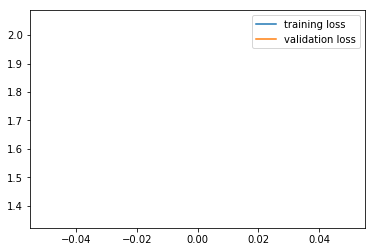

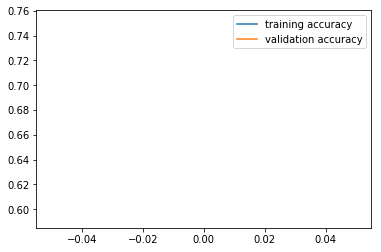

In [8]:
tch_sess = tf.Session(graph=tch_graph)
with tch_sess.as_default():
    with tch_graph.as_default():
        # TENSORBOARD - To visialize the architecture
        with tf.variable_scope('tensorboard') as scope:
            tf_summary_writer = tf.summary.FileWriter(TENSORBOARD_DIR, graph=tch_sess.graph)
            tf_dummy_summary = tf.summary.scalar(name="dummy", tensor=1)

        n_epochs = 1
        print_every = 32
        batch_size = 64 # small batch size so inception v3 can be run on laptops
        steps_per_epoch = len(X_train)//batch_size
        steps_per_epoch_val = len(X_test)//batch_size

        tch_sess.run(tf.global_variables_initializer())
        tch_pretrained_saver.restore(tch_sess, TCH_PRETRAINED_SNAPSHOT_FILE)
        
        redu_lenrate = ReduceLearningRate(
            init_val=0.0001, threthold=0.005, cnt_max=5) # initial value, threthold, cnt

        val_accuracy_list = []
        tra_accuracy_list = []
        val_loss_list = []
        tra_loss_list = []
        
        for epoch in range(n_epochs):
            print("----------------------------------------------", flush=True)
            print("EPOCH {}/{}".format(epoch+1, n_epochs), flush=True, end=' ')
            #print("----------------------------------------------", flush=True)
            learn_rate = redu_lenrate.get_rate(val_accuracy_list)
            tra_loss = []
            tra_accuracy = []
            for step in tqdm(range(steps_per_epoch)):
                # EXTRACT A BATCH OF TRAINING DATA
                X_batch = X_train[batch_size*step: batch_size*(step+1)]
                Y_batch = Y_train[batch_size*step: batch_size*(step+1)]

                # RUN ONE TRAINING STEP - feeding batch of data
                feed_dict = {tch_X: X_batch,
                             tch_Y: Y_batch,
                             tch_alpha:learn_rate,
                             tch_is_training: True}
                loss, _ = tch_sess.run([tch_loss, tch_train_op], feed_dict=feed_dict)
                tra_loss.append(loss)
                
                feed_dict = {tch_X: X_batch,
                             tch_Y: Y_batch,
                             tch_is_training: False}
                acu = tch_sess.run([tch_accuracy], feed_dict=feed_dict)
                tra_accuracy.append(acu)
                
            total_tra_loss = np.average(np.asarray(tra_loss))
            total_tra_accuracy = np.average(np.asarray(tra_accuracy))
            tra_loss_list.append(total_tra_loss)
            tra_accuracy_list.append(total_tra_accuracy)

            val_accuracy = []
            val_loss = []
            for step in tqdm(range(steps_per_epoch_val)):
                # EXTRACT A BATCH OF TEST DATA
                X_batch = X_test[batch_size*step: batch_size*(step+1)]
                Y_batch = Y_test[batch_size*step: batch_size*(step+1)]

                # Evalution
                feed_dict = {tch_X: X_batch,
                             tch_Y: Y_batch,
                             tch_is_training: False}            
                #val_accuracy.append(tch_accuracy.eval(feed_dict=feed_dict))
                
                loss, acu = tch_sess.run([tch_loss, tch_accuracy], feed_dict=feed_dict)
                val_accuracy.append(acu)
                val_loss.append(loss)
                
                
            total_val_accuracy = np.average(np.asarray(val_accuracy))
            total_val_loss = np.average(np.asarray(val_loss))
            val_accuracy_list.append(total_val_accuracy)
            val_loss_list.append(total_val_loss)

            print("\tstep: {: 4d}  tra loss: {:0.4f} val accuracy: {:0.4f}".format(
                        step, total_tra_loss, total_val_accuracy))

            plt.plot(tra_loss_list, label='training loss')
            plt.plot(val_loss_list, label='validation loss')
            plt.legend()
            plt.show()
            plt.plot(tra_accuracy_list, label='training accuracy')
            plt.plot(val_accuracy_list, label='validation accuracy')
            plt.legend()
            plt.show()

            # PRINT FEED BACK - once every `print_every` steps
#             total_val_accuracy = np.average(np.asarray(val_accuracy))
#             print("\tstep: {: 4d}  loss: {:0.4f} val accuracy: {:0.4f}".format(
#                         step, loss, total_val_accuracy))
#             plt.plot(tch_sess.run(tch_logits, feed_dict = {
#                 tch_X: [X_test[epoch]],
#                 tch_Y: [Y_test[epoch]],
#                 tch_is_training: False
#             })[0])
#             plt.show()
            # SAVE SNAPSHOT - after each epoch
            #tf_saver.save(sess, SNAPSHOT_FILE)

INFO:tensorflow:Restoring parameters from ./models/mobilenet/mobilenet_v1_0.5_160.ckpt
----------------------------------------------
EPOCH 1/1 lean rate :  0.0001



100%|██████████| 108/108 [00:21<00:00,  6.13it/s]

100%|██████████| 27/27 [00:01<00:00, 22.33it/s]

	step:   26  tra loss: 5.9902  tra acc: 0.3299 val loss: 5.8090 val acc: 0.4416


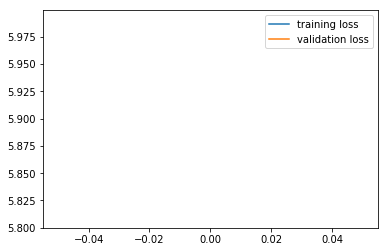

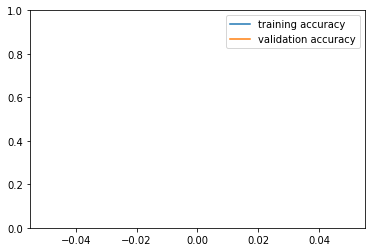

In [9]:
with tf.Session(graph=stu_graph) as sess:
    # TENSORBOARD - To visialize the architecture
    with tf.variable_scope('tensorboard') as scope:
        tf_summary_writer = tf.summary.FileWriter(TENSORBOARD_DIR, graph=sess.graph)
        tf_dummy_summary = tf.summary.scalar(name="dummy", tensor=1)
        
    n_epochs = 1
    print_every = 32
    batch_size = 64 # small batch size so inception v3 can be run on laptops
    steps_per_epoch = len(X_train)//batch_size
    steps_per_epoch_val = len(X_test)//batch_size

    sess.run(tf.global_variables_initializer())
    stu_pretrained_saver.restore(sess, STU_PRETRAINED_SNAPSHOT_FILE)
    
    redu_lenrate = ReduceLearningRate(
        init_val=0.0001, threthold=0.005, cnt_max=5) # initial value, threthold, cnt

    val_accuracy_list = []
    tra_accuracy_list = []
    val_loss_list = []
    tra_loss_list = []
    for epoch in range(n_epochs):
        print("----------------------------------------------", flush=True)
        print("EPOCH {}/{}".format(epoch+1, n_epochs), flush=True, end=' ')
        #print("----------------------------------------------", flush=True)
        
        learn_rate = redu_lenrate.get_rate(val_accuracy_list)
        
        tra_loss = []
        tra_accuracy = []
        for step in tqdm(range(steps_per_epoch)):
            # EXTRACT A BATCH OF TRAINING DATA
            X_batch = X_train[batch_size*step: batch_size*(step+1)]
            Y_batch = Y_train[batch_size*step: batch_size*(step+1)]
            
            logits_of_tch = tch_sess.run(tch_logits, feed_dict = {
                tch_X: [X_test[epoch]],
                tch_Y: [Y_test[epoch]],
                tch_is_training: False
            })

            # RUN ONE TRAINING STEP - feeding batch of data
            feed_dict = {stu_X: X_batch,
                         stu_Y: Y_batch,
                         #stu_alpha:0.0001,
                         stu_alpha: learn_rate,
                         stu_is_training: True,
                         stu_tch_logits: logits_of_tch}
            loss, _ = sess.run([stu_loss, stu_train_op], feed_dict=feed_dict)
            tra_loss.append(loss)
            
            feed_dict = {stu_X: X_batch,
                         stu_Y: Y_batch,
                         stu_is_training: False}
            acu = sess.run([stu_accuracy], feed_dict=feed_dict)
            tra_accuracy.append(acu)
            
#         total_tra_loss = np.average(np.asarray(tra_loss))
#         tra_loss_list.append(total_tra_loss)
        
        total_tra_loss = np.average(np.asarray(tra_loss))
        total_tra_accuracy = np.average(np.asarray(tra_accuracy))
        tra_loss_list.append(total_tra_loss)
        tra_accuracy_list.append(total_tra_accuracy)
            
        val_accuracy = []
        val_loss = []
        for step in tqdm(range(steps_per_epoch_val)):
            # EXTRACT A BATCH OF TEST DATA
            X_batch = X_test[batch_size*step: batch_size*(step+1)]
            Y_batch = Y_test[batch_size*step: batch_size*(step+1)]
            
            # Evalution
            feed_dict = {stu_X: X_batch,
                         stu_Y: Y_batch,
                         stu_is_training: False,
                         stu_tch_logits: logits_of_tch}            
            loss, acu = sess.run([stu_loss, stu_accuracy], feed_dict=feed_dict)
            val_accuracy.append(acu)
            val_loss.append(loss)
            #val_accuracy.append(stu_accuracy.eval(feed_dict=feed_dict))
            
        # PRINT FEED BACK - once every `print_every` steps
        total_val_accuracy = np.average(np.asarray(val_accuracy))
        total_val_loss = np.average(np.asarray(val_loss))
        val_accuracy_list.append(total_val_accuracy)
        val_loss_list.append(total_val_loss)
        
        print("\tstep: {: 4d}  tra loss: {:0.4f}  tra acc: {:0.4f} val loss: {:0.4f} val acc: {:0.4f}".format(
                    step,
                    total_tra_loss,
                    total_tra_accuracy,
                    total_val_loss,
                    total_val_accuracy))
        
        plt.plot(tra_loss_list, label='training loss')
        plt.plot(val_loss_list, label='validation loss')
        plt.legend()
        plt.show()
        plt.plot(tra_accuracy_list, label='training accuracy')
        plt.plot(val_accuracy_list, label='validation accuracy')
        plt.legend()
        plt.ylim(0, 1.0)
        plt.show()
        
        
        
        
#         plt.plot(tra_loss_list)
#         plt.plot(val_loss_list)
#         plt.show()
#         plt.plot(val_accuracy_list)
#         plt.show()

#         plt.plot(sess.run(stu_logits, feed_dict = {
#             stu_X: [X_test[epoch]],
#             stu_Y: [Y_test[epoch]],
#             stu_is_training: False
#         })[0])
#         plt.show()
        #xxffftfc6
        
        # SAVE SNAPSHOT - after each epoch
        #tf_saver.save(sess, SNAPSHOT_FILE)

teacher : 0.8443  
student : 0.7870  
su : 0.8119

teacher :   
student :   
  
mbnet : 0.7986  

bakusoku dec learn rate  
mbnet : 0.8947
  
cnt_max=10 dec learn rate  
mbnet : 0.8906 (130epoch)

In [10]:
#sess.close()
tch_sess.close()

end = time.time()
print("Time : {0}".format(end-start))

Time : 156.74596691131592


val accuracy: 0.8403